### Create a BigQuery Model

In [1]:
%load_ext google.cloud.bigquery

In [6]:
%%bigquery

CREATE OR REPLACE MODEL `bqml_demos.classification_model_3`
OPTIONS
(
model_type='logistic_reg',
labels = ['will_buy_on_return_visit']
)
AS
#standardSQL
SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430') # train on first 9 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
;

Query complete after 0.02s: 100%|██████████| 3/3 [00:00<00:00, 3167.11query/s]                        


""


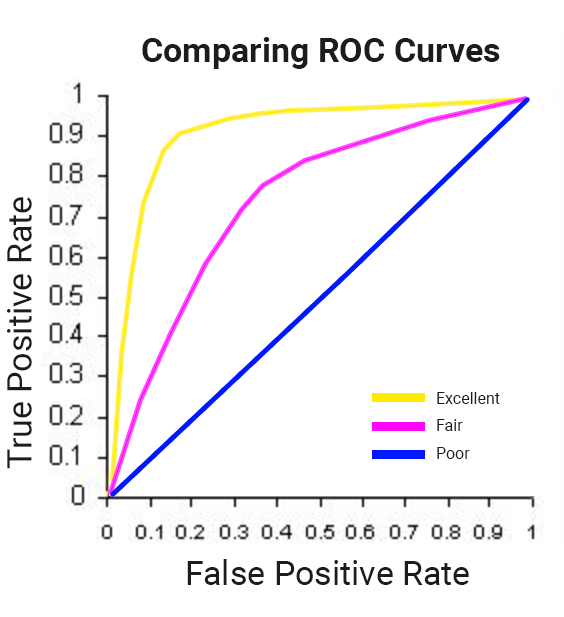

In [4]:
from IPython import display
display.Image("images/vertex-bqml-roc.png")

### Evaluating

In [6]:
%%bigquery

SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'decent'
    WHEN roc_auc > .6 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL bqml_demos.classification_model_3,  (
SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630') # eval on 2 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
));

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.59s/rows]


,roc_auc,model_quality
0,0.723831,decent


### Improving Model

In [7]:
%%bigquery

CREATE OR REPLACE MODEL `bqml_demos.classification_model_4`
OPTIONS
  (model_type='logistic_reg', labels = ['will_buy_on_return_visit']) AS
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
# add in new features
SELECT * EXCEPT(unique_session_id) FROM (
  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      IFNULL(totals.pageviews, 0) AS pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430' # train 9 months
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
);

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 2841.67query/s]                        


""


In [10]:
%%bigquery

#standardSQL
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'decent'
    WHEN roc_auc > .6 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL jchavezar.classification_model_4,  (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
# add in new features
SELECT * EXCEPT(unique_session_id) FROM (
  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630' # eval 2 months
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
));

Executing query with job ID: fff4e94d-725f-4ca0-bad2-5e153fe9e726
Query executing: 0.39s


ERROR:
 404 Not found: Dataset jchavezar-demo:jchavezar was not found in location US

Location: US
Job ID: fff4e94d-725f-4ca0-bad2-5e153fe9e726



In [11]:
%%bigquery

SELECT
*
FROM
  ml.PREDICT(MODEL `bqml_demos.classification_model_4`,
   (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
)
ORDER BY
  predicted_will_buy_on_return_visit DESC;

Downloading: 100%|██████████| 59602/59602 [00:01<00:00, 40836.02rows/s]


,predicted_will_buy_on_return_visit,predicted_will_buy_on_return_visit_probs,unique_session_id,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,1,"[{'label': 1, 'prob': 0.512787584111979}, {'la...",7481916632827440838-1501198926,1,4,0,2270,27.0,gdeals.googleplex.com,referral,Referral,desktop,United States
1,1,"[{'label': 1, 'prob': 0.6526042681918356}, {'l...",8946235742138524977-1501001777,0,4,0,5962,80.0,mall.googleplex.com,referral,Referral,desktop,United States
2,1,"[{'label': 1, 'prob': 0.5646009874172875}, {'l...",5177128356817703126-1500354345,0,6,0,397,18.0,sites.google.com,referral,Referral,desktop,United States
3,1,"[{'label': 1, 'prob': 0.5794229935597688}, {'l...",1598279880267775288-1500573148,0,6,0,1348,18.0,gdeals.googleplex.com,referral,Referral,desktop,United States
4,1,"[{'label': 1, 'prob': 0.591435411843993}, {'la...",3606489374690200823-1501130251,1,5,0,2370,20.0,sites.google.com,referral,Referral,desktop,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59597,0,"[{'label': 1, 'prob': 0.00528786658973402}, {'...",2577005515154248957-1501177138,0,0,0,121,3.0,youtube.com,referral,Social,desktop,Romania
59598,0,"[{'label': 1, 'prob': 0.007090356957853985}, {...",7582261539527099659-1500270143,0,0,0,85,3.0,m.facebook.com,referral,Social,mobile,United States
59599,0,"[{'label': 1, 'prob': 0.009842112431380374}, {...",1671504134842863799-1500187178,0,0,0,72,3.0,youtube.com,referral,Social,desktop,United States
59600,0,"[{'label': 1, 'prob': 0.00528645921743707}, {'...",1516264646025877273-1500100000,0,0,0,117,3.0,youtube.com,referral,Social,desktop,India


### Explainable AI

In [14]:
%%bigquery

SELECT * FROM ML.EXPLAIN_PREDICT(MODEL bqml_demos.classification_model_4, (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)

)

Downloading:   0%|          | 0/59602 [00:00<?, ?rows/s]